In [27]:
%load_ext autoreload
%autoreload 2

import os, json
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from mpl_toolkits.mplot3d import axes3d, Axes3D
import scipy.io as spio
from scipy import stats
import pandas as pd
import pickle

import ccf_analysis_utils
import functions as func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
def get_single_area_inds(area, df, ccf_labels):
    subregion_labels = func.get_all_subregion_annotations_from_name(df, area)['region'].values
    inds = func.get_neuron_inds_for_subregions(ccf_labels, {area: subregion_labels})
    return inds[area]

In [29]:
figfolder = 'figs/othercortex/'

if not os.path.exists(figfolder):
    os.makedirs(figfolder)

In [30]:
df = pd.read_excel('mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx',engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)

r2_new = pickle.load(open('r2_data_dict_timeshifts.pkl', 'rb'))

ccf_labels = r2_new['5_0']['ccf_labels'].copy()
is_alm = r2_new['5_0']['is_alm'].copy()

alm_inds = np.where(is_alm)[0]
areas = ['Medulla','Midbrain','ALM', 'Striatum', 'Thalamus',]

epochs = ['sample','delay','response']
r2_methods = ['old', 'old_clipped', 'new']

method_to_string = {'old': '_old', 'old_clipped': '_old', 'new': ''}

In [31]:
timeshifts = [-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16]
timeshifts = np.array(timeshifts)

In [32]:
cortex_subregions = func.get_n_layer_down_subregions_from_name(df, 'Isocortex', 1)['region'].values
cortex_subregions_annotations = {}
for subregion in cortex_subregions:
    cortex_subregions_annotations[subregion] = func.get_all_subregion_annotations_from_name(df, subregion)['region'].values
inds = func.get_neuron_inds_for_subregions(ccf_labels, cortex_subregions_annotations)
n_neurons = [v.shape[0] for v in inds.values()]
n_neurons

[34, 4386, 2280, 164, 95, 260, 18, 24, 149, 11, 5318, 510, 302, 0, 189, 29, 0]

In [33]:
def remove_empty_elements_from_dict(d):
    """
    Remove elements from a dictionary where the value is considered empty.
    An empty value could be None, '', [], {}, etc.
    """
    return {k: v for k, v in d.items() if len(v) != 0}

In [34]:
inds = remove_empty_elements_from_dict(inds)
n_neurons = [v.shape[0] for v in inds.values()]
n_neurons

[34, 4386, 2280, 164, 95, 260, 18, 24, 149, 11, 5318, 510, 302, 189, 29]

In [35]:
use_cortex_subregions = list(inds.keys())

In [36]:
inds

{'Frontal pole, cerebral cortex': array([ 1241, 20590, 25119, 25120, 25121, 25122, 25123, 25124, 25125,
        25126, 25127, 25128, 25129, 25130, 25131, 25138, 25139, 25141,
        25441, 25442, 25443, 25444, 25445, 25638, 25639, 25640, 25641,
        25642, 25643, 25644, 25645, 25646, 25647, 25648]),
 'Somatomotor areas': array([ 7531,  7532,  7533, ..., 33154, 33162, 33163]),
 'Somatosensory areas': array([15372, 15373, 15374, ..., 40446, 40503, 40530]),
 'Gustatory areas': array([23329, 23428, 23330, 23331, 23332, 23333, 23334, 23335, 23336,
        23337, 23338, 23339, 23340, 23341, 23342, 23343, 23344, 23345,
        23346, 23347, 23348, 23349, 23350, 23429, 23430, 23431, 23432,
        23433, 23434, 23435, 23436, 23437, 23438, 23439, 23440, 23351,
        23352, 23353, 23354, 23441, 23442, 31264, 31265, 31266, 31267,
        31268, 31269, 31270, 31271, 31272, 31273, 31274, 31275, 31276,
        31277, 31278, 31279, 31280, 31281, 31392, 31393, 31394, 31395,
        31396,  4881,

In [37]:
epoch = 'response'
r2_method = 'old_clipped'

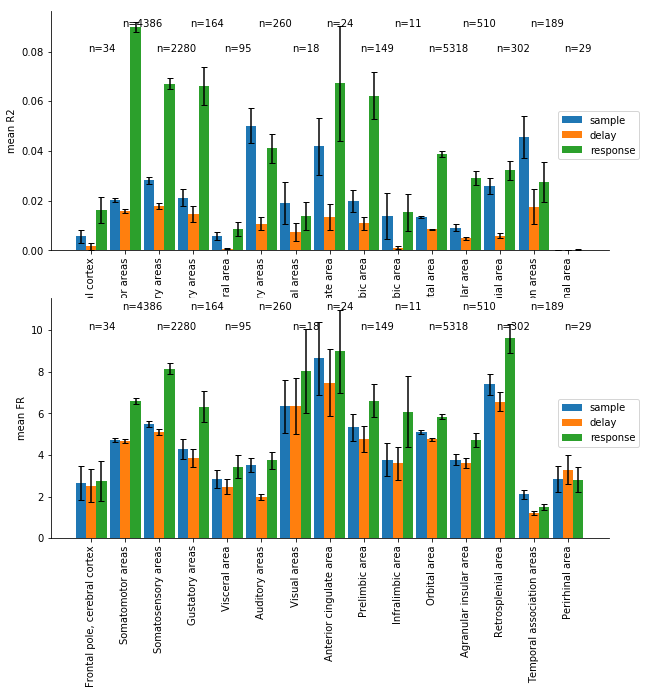

In [38]:
f = plt.figure(figsize=(10,15))
cc = ['grey','blue','green']
epoch_ls = ['dashed','dotted','solid']

ax_bar = f.add_subplot(3,1,1)
for iepoch,epoch in enumerate(epochs):
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    m, sem = func.get_mean_and_sem_for_subregions(r2, inds, use_cortex_subregions)
    plt.bar(np.arange(0,len(m)) + (- 0.3 + iepoch*0.3), 
                m, yerr = sem, alpha = 1, 
                capsize = 3, width=0.3, label = epoch)
    
for i in range(len(n_neurons)):
    ax_bar.text(i-0.1, 0.08 + 0.01 * (i%2), 'n=%d' % n_neurons[i], fontsize=10, color='black')
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.legend(bbox_to_anchor=(0.9,0.6))
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(use_cortex_subregions, rotation = 90)
_ = ax_bar.set_ylabel('mean R2')

ax_bar = f.add_subplot(3,1,2)
for iepoch,epoch in enumerate(epochs):
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    m, sem = func.get_mean_and_sem_for_subregions(fr, inds, use_cortex_subregions)
    plt.bar(np.arange(0,len(m)) + (- 0.3 + iepoch*0.3), 
                m, yerr = sem, alpha = 1, 
                capsize = 3, width=0.3, label = epoch)
    
for i in range(len(n_neurons)):
    ax_bar.text(i-0.1, 10 + 1 * (i%2), 'n=%d' % n_neurons[i], fontsize=10, color='black')
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.legend(bbox_to_anchor=(0.9,0.6))
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(use_cortex_subregions, rotation = 90)
_ = ax_bar.set_ylabel('mean FR')

plt.savefig(figfolder + 'cortex_subregions_r2_fr_%s%s.png'%(r2_method, method_to_string[r2_method]), bbox_inches='tight')

In [39]:
use_cortex_list = ['Somatosensory areas',
                   'Somatomotor areas',
                   'Auditory areas',
                   'Orbital area',
                   'Agranular insular area',
                   'Retrosplenial area',]



In [40]:
n_neurons = [v.shape[0] for k,v in inds.items() if k in use_cortex_list]

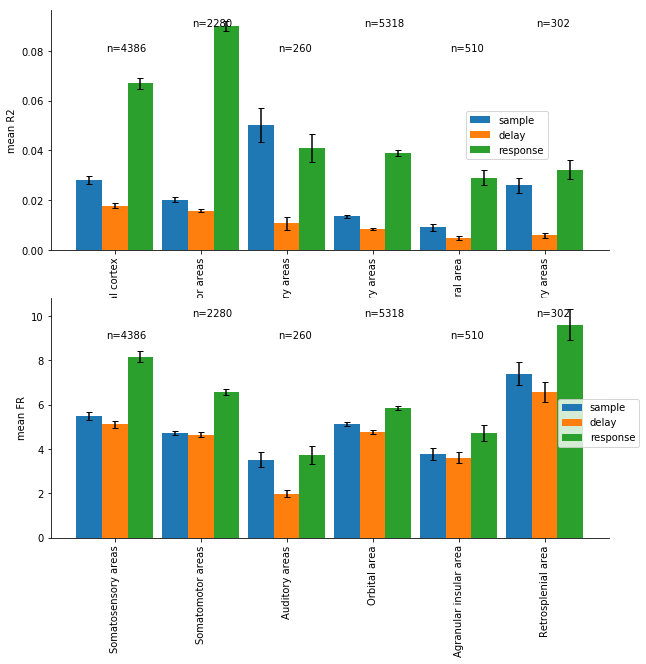

In [41]:
f = plt.figure(figsize=(10,15))
cc = ['grey','blue','green']
epoch_ls = ['dashed','dotted','solid']

ax_bar = f.add_subplot(3,1,1)
for iepoch,epoch in enumerate(epochs):
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    m, sem = func.get_mean_and_sem_for_subregions(r2, inds, use_cortex_list)
    plt.bar(np.arange(0,len(m)) + (- 0.3 + iepoch*0.3), 
                m, yerr = sem, alpha = 1, 
                capsize = 3, width=0.3, label = epoch)
    
for i in range(len(n_neurons)):
    ax_bar.text(i-0.1, 0.08 + 0.01 * (i%2), 'n=%d' % n_neurons[i], fontsize=10, color='black')
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.legend(bbox_to_anchor=(0.9,0.6))
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(use_cortex_subregions, rotation = 90)
_ = ax_bar.set_ylabel('mean R2')

ax_bar = f.add_subplot(3,1,2)
for iepoch,epoch in enumerate(epochs):
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    m, sem = func.get_mean_and_sem_for_subregions(fr, inds, use_cortex_list)
    plt.bar(np.arange(0,len(m)) + (- 0.3 + iepoch*0.3), 
                m, yerr = sem, alpha = 1, 
                capsize = 3, width=0.3, label = epoch)
    
for i in range(len(n_neurons)):
    ax_bar.text(i-0.1, 9 + 1 * (i%2), 'n=%d' % n_neurons[i], fontsize=10, color='black')
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.legend(bbox_to_anchor=(0.9,0.6))
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(use_cortex_list, rotation = 90)
_ = ax_bar.set_ylabel('mean FR')

plt.savefig(figfolder + 'cortex_subregions_select_r2_fr_%s%s.png'%(r2_method, method_to_string[r2_method]), bbox_inches='tight')

Exclude ALM

In [42]:
no_alm_inds = {k:np.setdiff1d(v,alm_inds) for k,v in inds.items()}

In [43]:
n_neurons = [v.shape[0] for k,v in no_alm_inds.items() if k in use_cortex_list]

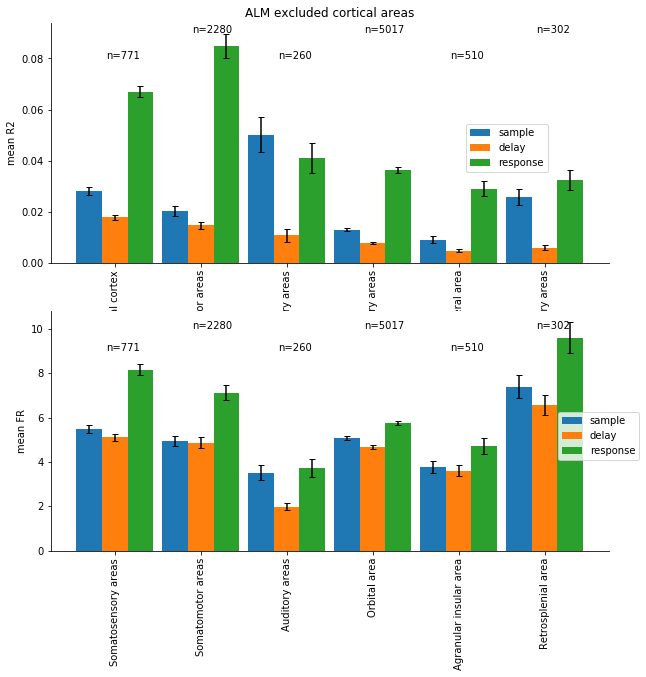

In [44]:
f = plt.figure(figsize=(10,15))
cc = ['grey','blue','green']
epoch_ls = ['dashed','dotted','solid']

ax_bar = f.add_subplot(3,1,1)
ax_bar.set_title('ALM excluded cortical areas')
for iepoch,epoch in enumerate(epochs):
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    m, sem = func.get_mean_and_sem_for_subregions(r2, no_alm_inds, use_cortex_list)
    plt.bar(np.arange(0,len(m)) + (- 0.3 + iepoch*0.3), 
                m, yerr = sem, alpha = 1, 
                capsize = 3, width=0.3, label = epoch)
    
for i in range(len(n_neurons)):
    ax_bar.text(i-0.1, 0.08 + 0.01 * (i%2), 'n=%d' % n_neurons[i], fontsize=10, color='black')
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.legend(bbox_to_anchor=(0.9,0.6))
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(use_cortex_subregions, rotation = 90)
_ = ax_bar.set_ylabel('mean R2')

ax_bar = f.add_subplot(3,1,2)
for iepoch,epoch in enumerate(epochs):
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    m, sem = func.get_mean_and_sem_for_subregions(fr, no_alm_inds, use_cortex_list)
    plt.bar(np.arange(0,len(m)) + (- 0.3 + iepoch*0.3), 
                m, yerr = sem, alpha = 1, 
                capsize = 3, width=0.3, label = epoch)
    
for i in range(len(n_neurons)):
    ax_bar.text(i-0.1, 9 + 1 * (i%2), 'n=%d' % n_neurons[i], fontsize=10, color='black')
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.legend(bbox_to_anchor=(0.9,0.6))
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(use_cortex_list, rotation = 90)
_ = ax_bar.set_ylabel('mean FR')

plt.savefig(figfolder + 'cortex_subregions_select_alm_excluded_r2_fr_%s%s.png'%(r2_method, method_to_string[r2_method]), bbox_inches='tight')

In [45]:
epoch = 'response'
r2_method = 'old_clipped'
r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
if r2_method == 'old_clipped':
    r2[r2<0] = 0

fr = r2_new['5_0']['%s_fr'%epoch].copy()

In [46]:
somatomotor_areas = func.get_n_layer_down_subregions_from_name(df, 'Somatomotor areas', 1)['region'].values
somatomotor_areas_annotations = {}
for subregion in somatomotor_areas:
    somatomotor_areas_annotations[subregion] = func.get_all_subregion_annotations_from_name(df, subregion)['region'].values

somatosensory_areas = func.get_n_layer_down_subregions_from_name(df, 'Somatosensory areas', 1)['region'].values
somatosensory_areas_annotations = {}
for subregion in somatosensory_areas:
    somatosensory_areas_annotations[subregion] = func.get_all_subregion_annotations_from_name(df, subregion)['region'].values

orbital_areas = func.get_n_layer_down_subregions_from_name(df, 'Orbital area', 1)['region'].values
orbital_areas_annotations = {}
for subregion in orbital_areas:
    orbital_areas_annotations[subregion] = func.get_all_subregion_annotations_from_name(df, subregion)['region'].values

somatomotor_inds = func.get_neuron_inds_for_subregions(ccf_labels, somatomotor_areas_annotations)
somatosensory_inds = func.get_neuron_inds_for_subregions(ccf_labels, somatosensory_areas_annotations)
orbital_inds = func.get_neuron_inds_for_subregions(ccf_labels, orbital_areas_annotations)

# filter alm
somatomotor_inds = {k:np.setdiff1d(v,alm_inds) for k,v in somatomotor_inds.items()}

joint_inds = {'ALM':alm_inds,**somatomotor_inds, **somatosensory_inds, **orbital_inds}

neuron_count = []
use_cortical_areas = []

neuron_threshold = 50
for k,v in joint_inds.items():
    if v.shape[0] > neuron_threshold:
        use_cortical_areas.append(k)
        neuron_count.append(v.shape[0])


In [47]:
col_list = [
    "black",    # Some kind of blue
    "skyblue",      # Some kind of blue
    "steelblue",    # Some kind of blue
    "lightgreen",   # Some kind of green
    "limegreen",    # Some kind of green
    "salmon",
    "tomato",
    "coral"
]


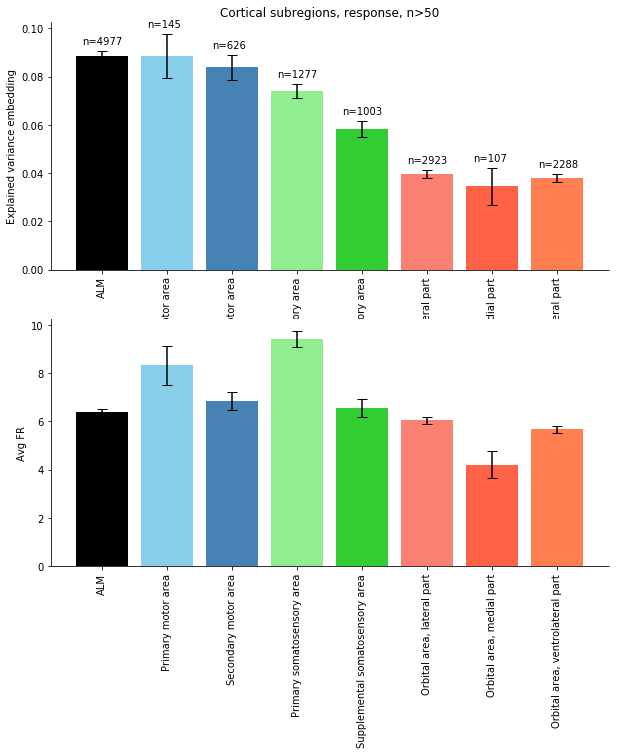

In [48]:
f = plt.figure(figsize=(10,10))
ax_bar = f.add_subplot(2,1,1)
ax_bar.set_title('Cortical subregions, response, n>%d'%neuron_threshold)
m, sem = func.get_mean_and_sem_for_subregions(r2, joint_inds, use_cortical_areas)
_ = func.plot_barplot_with_sem(ax_bar, m, sem, col_list, use_cortical_areas, 'Explained variance embedding', neuron_count)


ax_bar = f.add_subplot(2,1,2)
m_fr, sem_fr = func.get_mean_and_sem_for_subregions(fr, joint_inds, use_cortical_areas)
_ = func.plot_barplot_with_sem(ax_bar, m_fr, sem_fr, col_list, use_cortical_areas, 'Avg FR')

plt.savefig(figfolder + 'cortical_subregions.png', bbox_inches='tight')

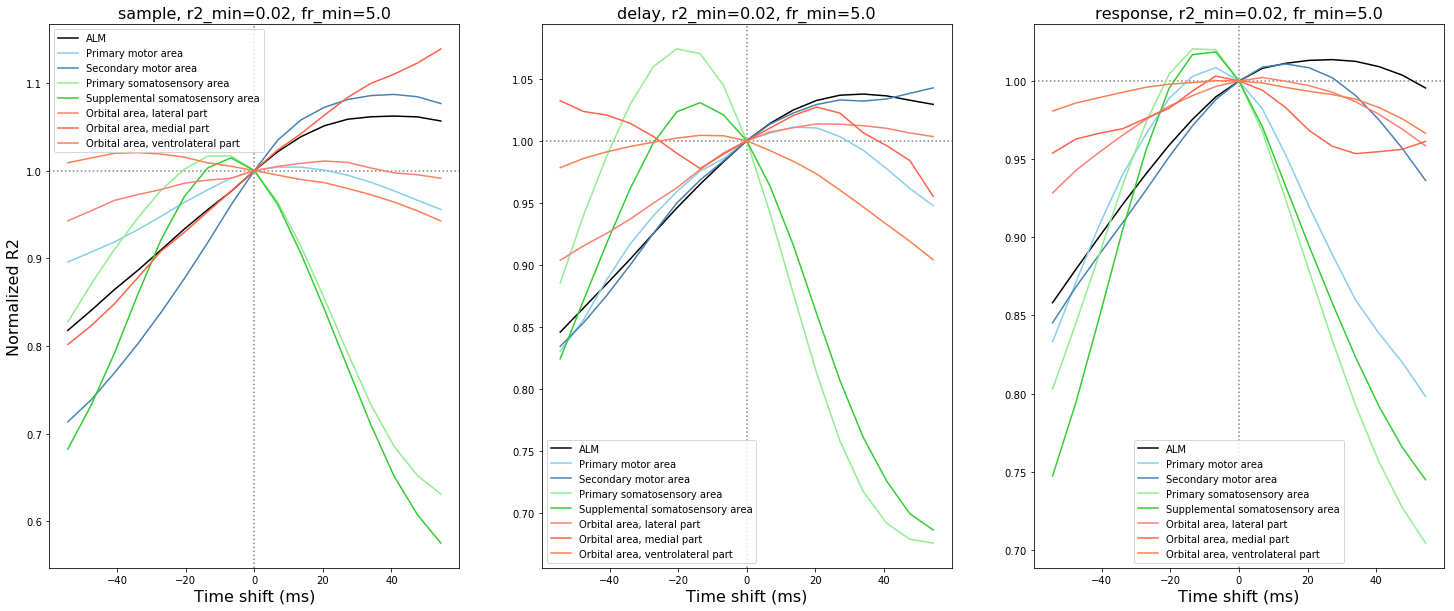

In [49]:
plt.subplots(1,3, figsize = (25,10))

lines_colors = ['b-', 'k--', 'g-', 'c-.', 'y-']

r2_threshold = .02
fr_threshold = 5.

for iepoch, epoch in enumerate(epochs):

    r2 = []

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    for timesh in timeshifts:
        r2.append(r2_new['5_%d'%timesh]['%s_r2'%epoch].copy())

    r2= np.array(r2)
    r2[r2<0] = 0

    fr_inds = np.where(fr > fr_threshold)[0]
    threshold_inds = np.where(r2[8,:] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)


    plt.subplot(1,3,iepoch+1)
    plt.title('%s, r2_min=%.2f, fr_min=%.1f'%(epoch,r2_threshold,fr_threshold), fontsize = 16)
    for j, area in enumerate(use_cortical_areas):
        inds = joint_inds[area]

        inds = np.intersect1d(inds, threshold_inds)
        avg_r2 = r2[:,inds].mean(axis = 1)

        plt.plot(timeshifts*3.4, avg_r2/avg_r2[8],color = col_list[j], label = area)
    a,b = plt.xlim()
    plt.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
    plt.xlim(a,b)

    a,b = plt.ylim()
    plt.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
    plt.ylim(a,b)

    plt.xlabel('Time shift (ms)', fontsize = 16)
    if iepoch == 0: plt.ylabel('Normalized R2', fontsize = 16)
    plt.legend()

plt.savefig(figfolder + 'normalized_r2_timeshifts_r2_fr_threshold_new.png', dpi = 300)

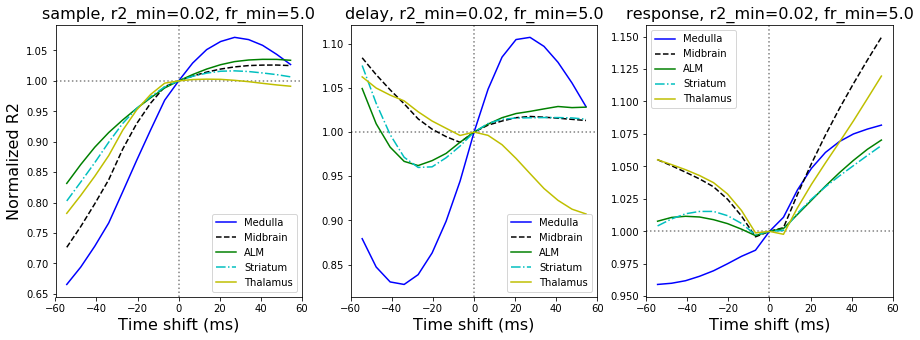

In [26]:
plt.subplots(1,3, figsize = (15,5))

lines_colors = ['b-', 'k--', 'g-', 'c-.', 'y-']

r2_threshold = .02
fr_threshold = 5.

for iepoch, epoch in enumerate(epochs):

    r2 = []

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    for timesh in timeshifts:
        r2.append(r2_new['5_%d'%timesh]['%s_r2_old'%epoch].copy())

    r2= np.array(r2)
    r2[r2<0] = 0

    fr_inds = np.where(fr > fr_threshold)[0]
    threshold_inds = np.where(r2[8,:] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)


    plt.subplot(1,3,iepoch+1)
    plt.title('%s, r2_min=%.2f, fr_min=%.1f'%(epoch,r2_threshold,fr_threshold), fontsize = 16)
    for j, area in enumerate(areas):
        if area == 'ALM':
            inds = alm_inds
        else:
            inds = get_single_area_inds(area, df, ccf_labels)

        inds = np.intersect1d(inds, threshold_inds)
        avg_r2 = r2[:,inds].mean(axis = 1)

        plt.plot(timeshifts*3.4, avg_r2/avg_r2[8],lines_colors[j], label = area)
    a,b = plt.xlim()
    plt.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
    plt.xlim(a,b)

    a,b = plt.ylim()
    plt.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
    plt.ylim(a,b)

    plt.xlabel('Time shift (ms)', fontsize = 16)
    if iepoch == 0: plt.ylabel('Normalized R2', fontsize = 16)
    plt.legend()

plt.savefig(figfolder + 'normalized_r2_timeshifts_r2_fr_threshold.png', dpi = 300)

This seems very interesting and different from the original paper...